In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

from src.emission import MLE_emission_parameters, new_MLE_emission_parameters_with_unknown, predict_y
from src.transition import MLE_transition_parameters
from src.viterbi import viterbi
from src.best_k_viterbi import get_stateset_and_wordset, convert_to_log_nonsparse_emission_dict, convert_to_log_nonsparse_tranmission_dict
from src.part_3 import part_3
from src.part_4 import *
from src.dataset_utils import parse_dataset
from src.eval_tools import evaluate_predictions

In [3]:
folder_dir = "RU"
train_dir = f"data/{folder_dir}/train"
test_dir = f"data/{folder_dir}/dev.in"
test_actual_dir = f"data/{folder_dir}/dev.out"

count_y_dict, count_y_to_x_dict, emission_dict = MLE_emission_parameters(train_dir)
emission_dict = new_MLE_emission_parameters_with_unknown(count_y_dict, count_y_to_x_dict, emission_dict, k=1)

# Part 2

# Find transition paramters
count_y_dict, count_y_to_y_dict, transition_dict = MLE_transition_parameters(train_dir)


# Part 3 
stateset, wordset = get_stateset_and_wordset(emission_dict,transition_dict)
nonsparse_emission_dict = convert_to_log_nonsparse_emission_dict(emission_dict,stateset,wordset)
nonsparse_transmission_dict = convert_to_log_nonsparse_tranmission_dict(transition_dict,stateset)

# Part 4
training_sentences = parse_dataset(train_dir)
log_dest_state_freq_dict = get_log_dest_state_freq_dict(stateset,training_sentences)
test_sentences = parse_dataset(test_dir,False)

In [18]:
def perform_part_4_trial(test_dir,stateset,training_sentences,test_sentences,log_dest_state_freq_dict,nonsparse_emission_dict,k,prefix="p4",regularization_count=0):
    output_dir = test_dir[:test_dir.index("dev.in")] + "p4_tests/{}_k{}_r{}.out".format(prefix,k,regularization_count)
    skipgram_log_transmission_params_dict_list = get_skipgram_log_transmission_params_dict_list(stateset,training_sentences,log_dest_state_freq_dict,k,regularization_count)
    
    output_lines = []
    for i in test_sentences:
        pred_seq = part_4_naffins_viterbi(i,nonsparse_emission_dict,skipgram_log_transmission_params_dict_list,stateset,k)
        pred_seq = pred_seq[1][1:-1]
        output_lines_interm = []
        for j in range(len(i)):
            output_lines_interm.append(" ".join([i[j]]+[pred_seq[j]]))
        output_lines.append("\n".join(output_lines_interm))
    output = "\n\n".join(output_lines) + "\n\n"
    
    with open(output_dir,"w", encoding="utf-8") as f:
        f.write(output)
    
    return

In [5]:
def perform_part_4_final(output_dir,stateset,training_sentences,test_sentences,log_dest_state_freq_dict,nonsparse_emission_dict,k,regularization_count=0):
    skipgram_log_transmission_params_dict_list = get_skipgram_log_transmission_params_dict_list(stateset,training_sentences,log_dest_state_freq_dict,k,regularization_count)
    
    output_lines = []
    for i in test_sentences:
        pred_seq = part_4_naffins_viterbi(i,nonsparse_emission_dict,skipgram_log_transmission_params_dict_list,stateset,k)
        pred_seq = pred_seq[1][1:-1]
        output_lines_interm = []
        for j in range(len(i)):
            output_lines_interm.append(" ".join([i[j]]+[pred_seq[j]]))
        output_lines.append("\n".join(output_lines_interm))
    output = "\n\n".join(output_lines) + "\n\n"
    
    with open(output_dir,"w", encoding="utf-8") as f:
        f.write(output)
    
    return

In [19]:
regularization_params = [0]
k_params = [1]
for i in regularization_params:
    for j in k_params:
        start_time = time.time()
        perform_part_4_trial(test_dir,stateset,training_sentences,test_sentences,log_dest_state_freq_dict,nonsparse_emission_dict,j,"dev.p4",i)
        print("Finished processing test dataset for regularization parameter={}, k={} in {}s".format(i,j,time.time()-start_time))

Finished processing test dataset for regularization parameter=0, k=1 in 0.7130527496337891s


In [16]:
def plot_trend(k_values,regularization_counts,test_actual_dir,dataset_name,prefix,is_entity=True,property="f",property_name="F-score"):
    evaluations = {i:{j:None for j in k_values} for i in regularization_counts}
    for i in regularization_counts:
        for j in k_values:
            test_predicted_dir = test_actual_dir[:test_actual_dir.rfind("/")] + "/p4_tests/{}_k{}_r{}.out".format(prefix,j,i)
            evaluations[i][j] = evaluate_predictions(test_actual_dir,test_predicted_dir)["Entity" if is_entity else "Sentiment"]
    for i in regularization_counts:
        values = [(j,evaluations[i][j][property]) for j in evaluations[i]]
        values = sorted(values,key=lambda x:x[0])
        f_scores = [i[1] for i in values]
        plt.plot(k_values,f_scores,label="r={}".format(i))
    plt.legend()
    plt.xlabel("k")
    plt.ylabel(property_name)
    plt.title("Plot of {} {} against k for {} dataset".format("entity" if is_entity else "sentiment",property_name,dataset_name))
    #plt.savefig("plots.pdf")

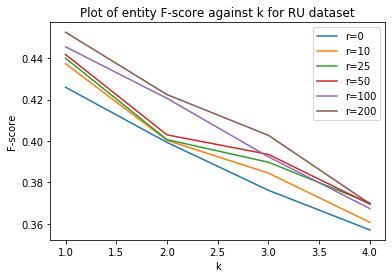

In [17]:
test_actual_dir = f"data/{folder_dir}/dev.out"

plot_trend([1,2,3,4],[0,10,25,50,100,200],test_actual_dir,folder_dir,"dev.p4",True,"f","F-score")

In [10]:
holdout_out_dir = f"data/{folder_dir}/test.p4.out"
holdout_dataset = parse_dataset(f"data/{folder_dir}/test.in",False)
perform_part_4_final(holdout_out_dir,stateset,training_sentences,holdout_dataset,log_dest_state_freq_dict,nonsparse_emission_dict,2,0) #ES
#perform_part_4_final(holdout_out_dir,stateset,training_sentences,holdout_dataset,log_dest_state_freq_dict,nonsparse_emission_dict,1,200) #RU